In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import datetime

## Import Data Source

In [4]:
data_src = "Raw-Agg Perf_Wk 2023021.csv"
df = pd.read_csv(data_src)
df.head(3)

,TM_KEY_MTH,TM_KEY_WK,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,DIMENSION_KPI_FLAG,BG_FLAG,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_AGG,TARGET_AGG,PPN_TM
0,202303,2023009,Digitalization,Digitalization,TRUE,All Services,DIS10015,% After-Sales Service via Digital Channels,N,N,N,0,GYR,%,M,13.96,20.0,2023-05-26 09:56:03
1,202303,2023012,Digitalization,Digitalization,TRUE,All Services,DIS10015,% After-Sales Service via Digital Channels,N,N,N,0,GYR,%,M,15.55,20.0,2023-05-26 09:56:03
2,202304,2023013,Digitalization,Digitalization,TRUE,All Services,DIS10015,% After-Sales Service via Digital Channels,N,N,N,0,GYR,%,M,14.20,20.0,2023-05-26 09:56:03


## Business Growth Data

In [10]:
df_bg = df[(df['BG_FLAG'] == 'Y') | ('METRIC_NAME' == 'TDG Revenue (Performance View)')]
df_bg.head(3)

,TM_KEY_MTH,TM_KEY_WK,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,DIMENSION_KPI_FLAG,BG_FLAG,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_AGG,TARGET_AGG,PPN_TM
408,202303,2023010,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,2.542705e+09,2.560220e+09,2023-05-26 09:56:03
409,202304,2023014,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,1.796362e+09,1.824547e+09,2023-05-26 09:56:03
410,202305,2023019,Sales & Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,Y,Y,S,0,GYR,baht,M,3.148715e+09,3.154019e+09,2023-05-26 09:56:03


## Visualization
##### https://matplotlib.org/stable/tutorials/introductory/pyplot.html

In [30]:
# BG rawdata
df_bg_agg = pd.DataFrame(df_bg.groupby(['TM_KEY_MTH', 'TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME']).agg({'ACTUAL_AGG': 'sum', 'TARGET_AGG': 'sum'}).reset_index())
df_bg_agg['ACTUAL_AGG'] = df_bg_agg['ACTUAL_AGG'] / 1000000
df_bg_agg['TARGET_AGG'] = df_bg_agg['TARGET_AGG'] / 1000000
df_bg_agg.head(3)

# df_bg_agg.to_csv('temp.csv')
# df_bg_agg.to_excel('temp.xlsx')

,TM_KEY_MTH,TM_KEY_WK,METRIC_CD,METRIC_NAME,ACTUAL_AGG,TARGET_AGG
0,202303,2023009,B1R000100,Prepaid Revenue,669.901008,626.219335
1,202303,2023009,B2R000100,Postpaid Revenue,1157.226110,1165.611851
2,202303,2023009,TB3R000100,TOL Revenue,189.713166,205.173356


### Monthly Performance

In [27]:
# Rawdata by month
df_bg_mth = df_bg_agg.groupby('TM_KEY_MTH').sum()[['ACTUAL_AGG','TARGET_AGG']].reset_index()
df_bg_mth['%ACHIEVE'] = (df_bg_mth['ACTUAL_AGG'] / df_bg_mth['TARGET_AGG']) * 100
df_bg_mth['ACTUAL_DIFF'] = df_bg_mth['ACTUAL_AGG'].diff()
df_bg_mth['LAST_MTH_ACTUAL'] = df_bg_mth['ACTUAL_AGG'] - df_bg_mth['ACTUAL_DIFF']

# Aggregation
x = df_bg_mth['TM_KEY_MTH'].apply(str).str[4:]
x_axis = np.arange(len(x))
y_act = df_bg_mth['ACTUAL_AGG'].round(2)
y_tgt = df_bg_mth['TARGET_AGG'].round(2)
y_ach = df_bg_mth['%ACHIEVE'].round(2)
y_diff = df_bg_mth['ACTUAL_DIFF'].round(2)
y_last_act = df_bg_mth['LAST_MTH_ACTUAL'].round(2)

df_bg_mth

,TM_KEY_MTH,ACTUAL_AGG,TARGET_AGG,%ACHIEVE,ACTUAL_DIFF,LAST_MTH_ACTUAL
0,202303,38853.323615,39332.934388,98.780638,NaN,NaN
1,202304,34478.092562,35148.679406,98.092142,-4375.231053,38853.323615
2,202305,27508.780117,27819.240211,98.884009,-6969.312445,34478.092562


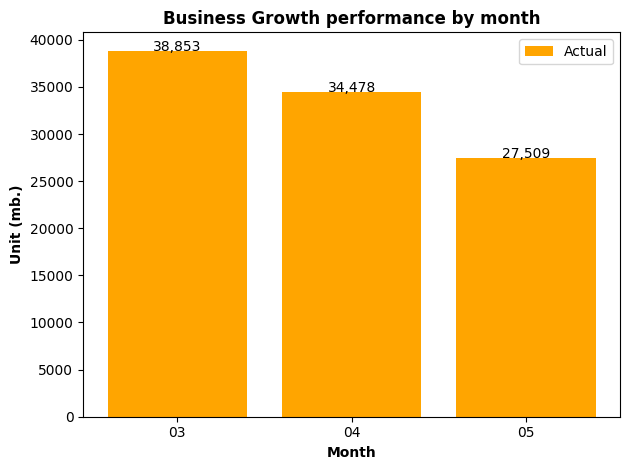

In [52]:
# plt.figure(figsize=(12,6))
# plt.figure().set_figwidth(12)

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')
    
plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title('Business Growth performance by month', fontdict={'fontweight': 'bold'})
plt.legend()

plt.tight_layout()
plt.show()

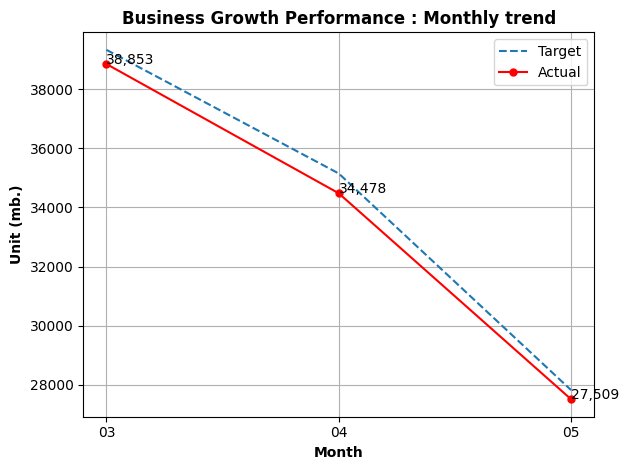

In [53]:
# plt.figure().set_figwidth(12)

plt.plot(x_axis, y_tgt, '--', markeredgewidth=3, label='Target')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='red')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]))

plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title('Business Growth Performance : Monthly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

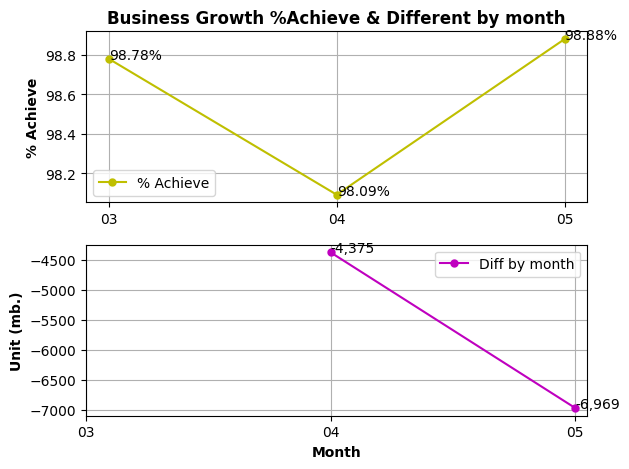

In [56]:
# plt.figure().set_figwidth(12)

plt.subplot(211)
plt.plot(x_axis, y_ach, marker='.', markeredgewidth=3, label='% Achieve', color='y')
for i in x_axis:
    plt.annotate(str(format(y_ach[i]/100,',.2%')), xy=(x_axis[i], y_ach[i]))
plt.xticks(x_axis, x)
plt.title('Business Growth %Achieve & Different by month', fontdict={'fontweight': 'bold'})
plt.ylabel('% Achieve', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x_axis, y_diff, marker='.', markeredgewidth=3, label='Diff by month', color='m')
for i in x_axis:
    plt.annotate(str(format(y_diff[i],',.0f')), xy=(x_axis[i], y_diff[i]))
plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()